# Sentiment analysis on US airline reviews

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding


# Preprocessing the data

In [2]:
#Load csv file
df = pd.read_csv('Tweets.csv')

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
#Drop all the other columns and remain with text and airline columns 
tweet_df = df[['text','airline_sentiment']]
print(tweet_df.shape)
tweet_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [6]:
#Drop the neutral values from airline_sentiment
tweet_df = tweet_df[tweet_df['airline_sentiment'] != 'neutral']
print(tweet_df.shape)
tweet_df.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [7]:
#Check the total number of positive and negative sentiments
tweet_df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
sentiment_label = tweet_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

In [9]:
#Change the categorical values to numeric values to be understood by the machine
tweet = tweet_df.text.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [10]:
print(tokenizer.word_index)

{'to': 1, 'the': 2, 'i': 3, 'a': 4, 'united': 5, 'you': 6, 'for': 7, 'flight': 8, 'and': 9, 'on': 10, 'my': 11, 'usairways': 12, 'americanair': 13, 'is': 14, 'in': 15, 'southwestair': 16, 'of': 17, 'jetblue': 18, 'me': 19, 'your': 20, 'it': 21, 'was': 22, 'not': 23, 'no': 24, 'have': 25, 'at': 26, 'with': 27, 'that': 28, 'this': 29, 'get': 30, 'but': 31, 'be': 32, 'cancelled': 33, 'thanks': 34, 'now': 35, 'service': 36, 'are': 37, 'we': 38, 'from': 39, 'an': 40, 'been': 41, 'just': 42, '2': 43, 'so': 44, 'customer': 45, 'help': 46, 't': 47, 'can': 48, 'time': 49, 'co': 50, 'up': 51, 'hours': 52, 'http': 53, 'do': 54, 'hold': 55, 'they': 56, 'out': 57, 'amp': 58, 'plane': 59, "i'm": 60, 'us': 61, 'all': 62, 'will': 63, 'why': 64, 'thank': 65, 'still': 66, 'our': 67, 'delayed': 68, 'what': 69, 'when': 70, 'how': 71, 'one': 72, "can't": 73, 'flights': 74, 'call': 75, 'gate': 76, 'hour': 77, 'had': 78, 'flightled': 79, 'back': 80, 'bag': 81, 'if': 82, 'would': 83, 'after': 84, 'has': 85, '

In [11]:
print(tweet[0])
print(encoded_docs[0])

@VirginAmerica plus you've added commercials to the experience... tacky.
[103, 575, 530, 1287, 2416, 1, 2, 177]


In [12]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  103  575  530 1287
 2416 

# Build text classifier

In [13]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
__________________________________________________

# Train the sentiment analysis model

In [14]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 78s 236ms/step - loss: 0.4060 - accuracy: 0.8323 - val_loss: 0.2054 - val_accuracy: 0.9220
Epoch 2/5
289/289 [==============================] - 72s 251ms/step - loss: 0.2140 - accuracy: 0.9172 - val_loss: 0.1662 - val_accuracy: 0.9411
Epoch 3/5
289/289 [==============================] - 75s 260ms/step - loss: 0.1621 - accuracy: 0.9386 - val_loss: 0.1643 - val_accuracy: 0.9420
Epoch 4/5
289/289 [==============================] - 70s 241ms/step - loss: 0.1313 - accuracy: 0.9508 - val_loss: 0.1713 - val_accuracy: 0.9428
Epoch 5/5
289/289 [==============================] - 70s 241ms/step - loss: 0.1142 - accuracy: 0.9579 - val_loss: 0.2307 - val_accuracy: 0.9411


The fit_on_text() creates an association between the text and the assigned numbers
Now replace the words with the assigned numbers using the text_to_sequence method

The model obtained a 95.7% accuracy on training data and 94.2% test data

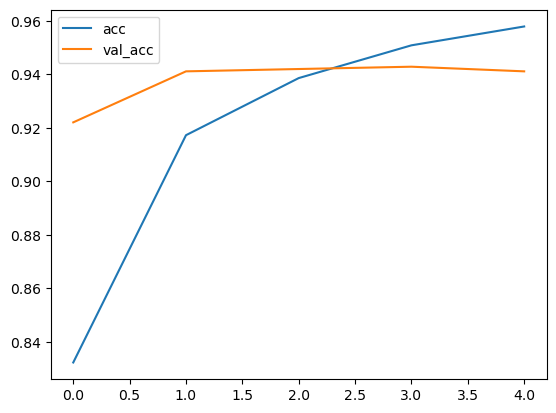

<Figure size 640x480 with 0 Axes>

In [15]:
#Use matplotlib to plot the metrics 
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

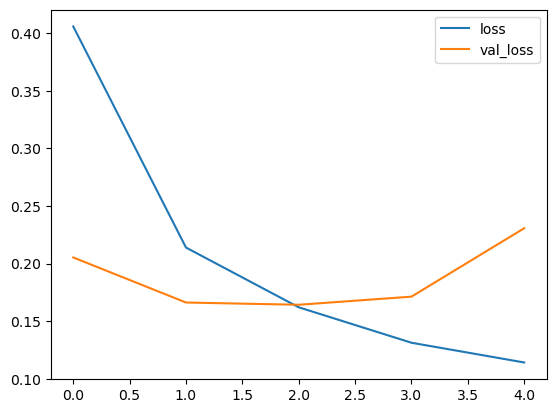

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

# Execute the sentiment analysis model

In [17]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [18]:
test_sentence1 = "I really enjoyed my flight"
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

test_sentence3 = "I loved the trip, the airline could charge less, but overall it was good"
predict_sentiment(test_sentence3)

1/1 [==============================] - 1s 625ms/step
Predicted label:  positive
1/1 [==============================] - 0s 53ms/step
Predicted label:  negative
1/1 [==============================] - 0s 42ms/step
Predicted label:  positive
